<a href="https://colab.research.google.com/github/Nishlesh/Monte-carlo/blob/main/NakedCall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Strike_1  Strike_2  Max_Profit  Max_Loss  Reward_Risk_Ratio  \
0    24300.0   24350.0      550.00    700.00           0.785714   
1    24300.0   24400.0     1025.00   1475.00           0.694915   
2    24300.0   24450.0     1840.00   1910.00           0.963351   
3    24300.0   24500.0     2400.00   2600.00           0.923077   
4    24250.0   24350.0      988.75   1511.25           0.654260   
5    24250.0   24400.0     1463.75   2286.25           0.640241   
6    24250.0   24450.0     2278.75   2721.25           0.837391   
7    24250.0   24500.0     2838.75   3411.25           0.832173   
8    24350.0   24400.0      475.00    775.00           0.612903   
9    24350.0   24450.0     1290.00   1210.00           1.066116   
10   24350.0   24500.0     1850.00   1900.00           0.973684   
11   24200.0   24400.0     1925.00   3075.00           0.626016   
12   24200.0   24450.0     2740.00   3510.00           0.780627   
13   24200.0   24500.0     3300.00   4200.00           0.78571

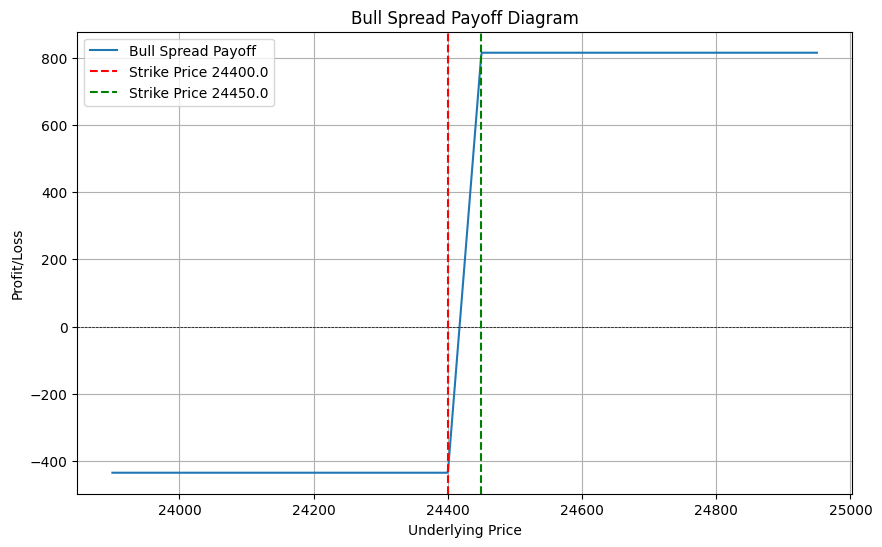

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-25-Jul-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 24324  # Current price of NIFTY
T = 20 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible bull spread combinations
bull_spreads = list(itertools.combinations(nearest_strikes, 2))
strategies = []

for (K1, K2) in bull_spreads:
    if K1 < K2:
        call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
        call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

        # Calculate max profit, max loss, reward/risk ratio, and probability of profit
        max_profit = (K2 - K1) - (call_price_1 - call_price_2)
        max_loss = call_price_1 - call_price_2
        reward_risk_ratio = max_profit / max_loss

        # Assuming probability of profit based on ATM strike and distance between strikes
        prob_profit = norm.cdf((np.log(S0 / K1) + (r - 0.5 * ((df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]+df_nearest[df_nearest['STRIKE'] == K2]['IV_CALLS'].values[0])/2) ** 2) * T) / ((df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]+df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0]) * np.sqrt(T)/2))

        strategies.append({
            'Strike_1': K1,
            'Strike_2': K2,
            'Max_Profit': max_profit * lot_size,
            'Max_Loss': max_loss * lot_size,
            'Reward_Risk_Ratio': reward_risk_ratio,
            'Probability_of_Profit': prob_profit
        })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)
# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Reward_Risk_Ratio': 0.5,
    'Probability_of_Profit': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Reward_Risk_Ratio', 'Probability_of_Profit', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
print(f"Top Bull Spread Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K1 = top_strategy['Strike_1']
K2 = top_strategy['Strike_2']
call_price_1 = df_nearest[df_nearest['STRIKE'] == K1]['Call_Price'].values[0]
call_price_2 = df_nearest[df_nearest['STRIKE'] == K2]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(min(K1, K2) - 500, max(K1, K2) + 500, 1000)

# Payoff function for the bull spread strategy
# Payoff function for the bull spread strategy
payoff = 25*np.where(
    S_range <= K1,
    -call_price_1 + call_price_2,
    np.where(
        (S_range > K1) & (S_range <= K2),
        S_range - K1 - call_price_1 + call_price_2,
        K2 - K1 - call_price_1 + call_price_2  # Payoff when S_range > K2
    )
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Bull Spread Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K1, color='r', linestyle='--', label=f'Strike Price {K1}')
plt.axvline(K2, color='g', linestyle='--', label=f'Strike Price {K2}')
plt.title('Bull Spread Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()


Top Long Strangle Strategy:
Strike_1                 24100.000000
Strike_2                 24050.000000
Max_Profit               22771.250000
Max_Loss                 22771.250000
Reward_Risk_Ratio            1.000000
Probability_of_Profit        0.942016
TOPSIS_Score                 1.000000
Rank                         1.000000
Name: 43, dtype: float64


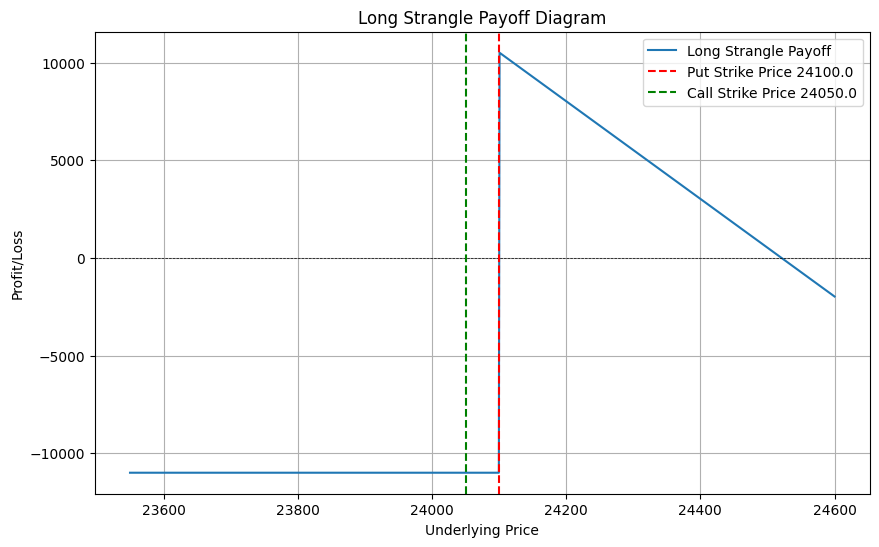

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-25-Jul-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'] / 100

# Define constants
S0 = 24324  # Current price of NIFTY
T = 20 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Option_Price'] = df_nearest['LTP_CALLS']

# Generate all possible long strangle combinations
long_strangles = list(itertools.combinations(nearest_strikes, 2))
strategies = []

for (K1, K2) in long_strangles:
    call_price = df_nearest[df_nearest['STRIKE'] == K2]['Option_Price'].values[0]
    put_price = df_nearest[df_nearest['STRIKE'] == K1]['Option_Price'].values[0]

    # Calculate max profit, max loss, reward/risk ratio, and probability of profit
    max_profit = call_price + put_price
    max_loss = call_price + put_price
    reward_risk_ratio = max_profit / max_loss

    # Assuming probability of profit based on ATM strike and distance between strikes
    prob_profit_call = norm.cdf((np.log(S0 / K2) + (r - 0.5 * df_nearest[df_nearest['STRIKE'] == K2]['IV_CALLS'].values[0] ** 2) * T) / (df_nearest[df_nearest['STRIKE'] == K2]['IV_CALLS'].values[0] * np.sqrt(T)))
    prob_profit_put = norm.cdf((np.log(S0 / K1) + (r - 0.5 * df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0] ** 2) * T) / (df_nearest[df_nearest['STRIKE'] == K1]['IV_CALLS'].values[0] * np.sqrt(T)))

    prob_profit = prob_profit_call + prob_profit_put - prob_profit_call * prob_profit_put

    strategies.append({
        'Strike_1': K1,
        'Strike_2': K2,
        'Max_Profit': max_profit * lot_size,
        'Max_Loss': max_loss * lot_size,
        'Reward_Risk_Ratio': reward_risk_ratio,
        'Probability_of_Profit': prob_profit
    })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)

# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Reward_Risk_Ratio': 0.5,
    'Probability_of_Profit': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Reward_Risk_Ratio', 'Probability_of_Profit', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
print(f"Top Long Strangle Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K1 = top_strategy['Strike_1']
K2 = top_strategy['Strike_2']
call_price = df_nearest[df_nearest['STRIKE'] == K2]['Option_Price'].values[0]
put_price = df_nearest[df_nearest['STRIKE'] == K1]['Option_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(min(K1, K2) - 500, max(K1, K2) + 500, 1000)

# Payoff function for the long strangle strategy
payoff = 25*np.where(
    S_range <= K1,
    -put_price,
    np.where(
        (S_range >= K2),
        call_price - (S_range - K2),
        call_price - put_price  # Payoff between K1 and K2
    )
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Long Strangle Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K1, color='r', linestyle='--', label=f'Put Strike Price {K1}')
plt.axvline(K2, color='g', linestyle='--', label=f'Call Strike Price {K2}')
plt.title('Long Strangle Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(option_chain("SBIN", "OPTSTK", "25JUL2024").tail())

TooManyRedirects: Exceeded 30 redirects.

In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.parse import urlencode

def np_float(x):
    try:
        y = x.lstrip().rstrip().replace(',','')
        return np.float64(y)
    except:
        return np.nan

def option_chain(symbol, instrument, date_="-"):
    base_url = "https://www1.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?"
    parameters = {
        "segmentLink": 17,
        "instrument": instrument,
        "symbol": symbol,
        "date": date_
    }
    url = base_url + urlencode(parameters)
    headers = {
        "Host": "www1.nseindia.com",
        "Referer": "https://www1.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp",
        "X-Requested-With": "XMLHttpRequest",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36",
        "Accept": "*/*",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8",
        "Cache-Control": "no-cache",
        "Connection": "keep-alive",
        }

    # Use a session to handle cookies and potential redirects
    with requests.Session() as s:
        s.get("https://www1.nseindia.com", headers=headers)  # Initial request to establish session and potentially get cookies
        r = s.get(url, headers=headers, allow_redirects=True)  # Allow redirects explicitly


    bs = BeautifulSoup(r.text, 'html.parser') # Explicitly set the parser
    table = bs.find("table", {"id": "octable"})
    if table is None:
        print("Error: 'octable' not found. The website structure might have changed.")
        return None

    # Get all rows
    table_rows = table.find_all('tr')

    l = []
    for tr in table_rows:
        td = tr.find_all('td')
        if td:
            row = [tr.text for tr in td]
            l.append(row)

    arr = []
    for r in l:
        row = [np_float(x) for x in r]
        arr.append(row)

    df = pd.DataFrame(arr[:-1])
    df.columns = ["CE Chart", "CE OI", "CE Change in OI", "CE Volume", "CE IV", "CE LTP", "CE Net Change", "CE Bid Qty", "CE Bid Price", "CE Ask Price", "CE Ask Quantity",
                 "Strike Price",
                 "PE Bid Qty", "PE Bid Price", "PE Ask Price", "PE Ask Qty", "PE Net Change", "PE LTP", "PE IV", "PE Volume", "PE Change in OI", "PE OI", "PE Chart"]
    return df

In [ ]:
import pandas as pd
from nsetools import Nse
from datetime import datetime, timedelta

def get_stock_data(symbol):
    nse = Nse()
    stock_data = nse.get_quote(symbol)
    return stock_data

def get_all_stock_symbols():
    nse = Nse()
    all_stock_codes = nse.get_stock_codes()
    symbols = [symbol for symbol in all_stock_codes if symbol != 'SYMBOL']
    return symbols

def calculate_percentage_change(initial, final):
    return ((final - initial) / initial) * 100

def get_worst_performing_stocks(num_stocks=10):
    nse = Nse()
    symbols = get_all_stock_symbols()
    one_year_ago = datetime.now() - timedelta(days=365)

    stock_performance = []

    for symbol in symbols:
        try:
            stock_data = get_stock_data(symbol)
            current_price = stock_data['lastPrice']
            historical_prices = nse.get_quote(symbol)  # This needs to be replaced with actual historical data fetching

            # Assuming we have a way to get the price from one year ago, replace with actual data fetching
            one_year_ago_price = historical_prices  # Placeholder, replace with actual historical price

            change_percentage = calculate_percentage_change(one_year_ago_price, current_price)
            stock_performance.append((symbol, change_percentage))
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    worst_performers = sorted(stock_performance, key=lambda x: x[1])[:num_stocks]
    return worst_performers

worst_stocks = get_worst_performing_stocks()
for stock in worst_stocks:
    print(f"Stock: {stock[0]}, Performance: {stock[1]:.2f}%")


HTTPError: HTTP Error 301: The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Moved Permanently

In [ ]:
pip install nsepy


  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36058 sha256=10e06302086fc77c008dfd3d7caab51294e84e21c9b67d16b195772b4b122b69
  Stored in directory: /root/.cache/pip/wheels/4c/87/cb/acaf83f625e5fc73e1fe6e2a8e97680c74cd72391850ef5a86
Successfully built nsepy


In [ ]:
import pandas as pd
from nsepy import get_history
from datetime import datetime, timedelta

# Function to get a list of NSE stock symbols
def get_stock_symbols():
    # Return a sample list of symbols
    return ['RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ICICIBANK']

# Function to get historical price of a stock symbol on a specific date
def get_historical_price(symbol, date):
    historical_data = get_history(symbol=symbol, start=date, end=date)
    if not historical_data.empty:
        return historical_data['Close'][0]
    return None

# Function to get the current price of a stock symbol
def get_current_price(symbol):
    today = datetime.now().date()
    current_data = get_history(symbol=symbol, start=today, end=today)
    if not current_data.empty:
        return current_data['Close'][0]
    return None

# Function to calculate the percentage change between two prices
def calculate_percentage_change(initial, final):
    return ((final - initial) / initial) * 100

# Function to get the worst-performing stocks over the past year
def get_worst_performing_stocks(num_stocks=10):
    symbols = get_stock_symbols()
    one_year_ago = (datetime.now() - timedelta(days=365)).date()
    stock_performance = []

    for symbol in symbols:
        try:
            current_price = get_current_price(symbol)
            if current_price is None:
                continue

            one_year_ago_price = get_historical_price(symbol, one_year_ago)
            if one_year_ago_price is None:
                continue

            change_percentage = calculate_percentage_change(one_year_ago_price, current_price)
            stock_performance.append((symbol, change_percentage))
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    worst_performers = sorted(stock_performance, key=lambda x: x[1])[:num_stocks]
    return worst_performers

# Get the worst-performing stocks and print the results
worst_stocks = get_worst_performing_stocks()
for stock in worst_stocks:
    print(f"Stock: {stock[0]}, Performance: {stock[1]:.2f}%")


Error fetching data for RELIANCE: Exceeded 30 redirects.
Error fetching data for TCS: Exceeded 30 redirects.
Error fetching data for INFY: Exceeded 30 redirects.
Error fetching data for HDFCBANK: Exceeded 30 redirects.


In [ ]:
import yfinance as yf

# Download Nifty 50 constituents (replace with a broader NSE list if needed)
nifty_50 = yf.download('^NSEI', start=pd.Timestamp('2024-01-01'), end=pd.Timestamp.today())
stock_list = nifty_50.tickers.tolist()


[*********************100%%**********************]  1 of 1 completed


AttributeError: 'DataFrame' object has no attribute 'tickers'

In [ ]:
import yfinance as yf
import pandas as pd
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta

# Function to get a list of NSE stock symbols
def get_stock_symbols():
    url = 'https://www1.nseindia.com/content/indices/ind_nifty50list.csv'
    symbols = []

    # Fetch the CSV content from NSE's website
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.content.decode('utf-8')
        df = pd.read_csv(pd.compat.StringIO(data))
        symbols = df['Symbol'].tolist()
    except Exception as e:
        print(f"Error fetching symbols: {e}")

    return symbols

# Function to calculate the percentage change between two prices
def calculate_percentage_change(initial, final):
    return ((final - initial) / initial) * 100

# Function to get the worst-performing stocks over the past year
def get_worst_performing_stocks(num_stocks=10):
    symbols = get_stock_symbols()
    one_year_ago = datetime.now() - timedelta(days=365)
    stock_performance = []

    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol + ".NS")
            hist = stock.history(period="1y")
            if not hist.empty:
                start_price = hist['Close'].iloc[0]
                end_price = hist['Close'].iloc[-1]
                change_percentage = calculate_percentage_change(start_price, end_price)
                stock_performance.append((symbol, change_percentage))
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    worst_performers = sorted(stock_performance, key=lambda x: x[1])[:num_stocks]
    return worst_performers

# Get the worst-performing stocks and print the results
worst_stocks = get_worst_performing_stocks()
for stock in worst_stocks:
    print(f"Stock: {stock[0]}, Performance: {stock[1]:.2f}%")


KeyboardInterrupt: 

In [ ]:
import yfinance as yf
import pandas as pd

# Define the stock symbol and the date of interest
stock_symbol = "RELIANCE.NS"
date_of_interest = "2024-07-05"

# Fetch the historical data for the stock
stock = yf.Ticker(stock_symbol)
hist = stock.history(start="2024-07-04", end="2024-07-06")  # Fetching a range to ensure the date is included

# Extract the close price for the date of interest
try:
    close_price = hist.loc[date_of_interest, "Close"]
    print(f"The close price of Reliance on {date_of_interest} was: {close_price:.2f}")
except KeyError:
    print(f"No data available for {date_of_interest}.")


The close price of Reliance on 2024-07-05 was: 3177.25


In [ ]:
import yfinance as yf
import pandas as pd
df = pd.read_csv('/content/EQUITY_L (1).csv')
# Define the stock symbols for NSE (only a few as an example, you can expand this list)


# Define the date of interest
date_of_interest = "2024-07-05"

# Initialize an empty dictionary to store the close prices
close_prices = {}

# Fetch the historical data for each stock and extract the close price for the date of interest
for symbol in df['SYMBOL']:
    stock = yf.Ticker(symbol+ ".NS")
    hist = stock.history(start="2024-07-04", end="2024-07-06")  # Fetching a range to ensure the date is included

    # Extract the close price for the date of interest
    try:
        close_price = hist.loc[date_of_interest, "Close"]
        close_prices[symbol] = close_price
    except KeyError:
        close_prices[symbol] = None  # If no data is available, store None

# Convert the dictionary to a Pandas Series


# Print the close prices series



ERROR:yfinance:BHANDA-RE1.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:KALYANI.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:MITCON-RE.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:SEPC-RE2.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:$SICALLOG.NS: possibly delisted; No price data found  (1d 2024-07-04 -> 2024-07-06)


$SICALLOG.NS: possibly delisted; No price data found  (1d 2024-07-04 -> 2024-07-06)


In [ ]:
# Convert the Series to a DataFrame
close_prices_series = pd.Series(close_prices)
close_prices_series.to_csv('close_prices.csv')
# Print the close prices series
print(close_prices_series)

20MICRONS       224.720001
21STCENMGM       73.489998
360ONE          964.700012
3IINFOLTD        40.209999
3MINDIA       38768.101562
                  ...     
ZOTA            594.000000
ZUARI           221.199997
ZUARIIND        388.200012
ZYDUSLIFE      1162.449951
ZYDUSWELL      2118.250000
Length: 2017, dtype: float64


In [ ]:
df1 = pd.DataFrame(close_prices_series)
df1.columns = ['price']
df1.index.name = 'SYMBOL'
df1.insert(0,'symbol',df1.index)
df1.reset_index(drop=True, inplace=True)
df1

,symbol,price
0,20MICRONS,224.720001
1,21STCENMGM,73.489998
2,360ONE,964.700012
3,3IINFOLTD,40.209999
4,3MINDIA,38768.101562
...,...,...
2012,ZOTA,594.000000
2013,ZUARI,221.199997
2014,ZUARIIND,388.200012
2015,ZYDUSLIFE,1162.449951


In [ ]:
import yfinance as yf
import pandas as pd
df = pd.read_csv('/content/EQUITY_L (1).csv')
# Define the stock symbols for NSE (only a few as an example, you can expand this list)


# Define the date of interest
date_of_interest1 = "2023-07-05"

# Initialize an empty dictionary to store the close prices
close_prices1 = {}

# Fetch the historical data for each stock and extract the close price for the date of interest
for symbol in df['SYMBOL']:
    stock = yf.Ticker(symbol+ ".NS")
    hist = stock.history(start="2023-07-04", end="2023-07-06")  # Fetching a range to ensure the date is included

    # Extract the close price for the date of interest
    try:
        close_price = hist.loc[date_of_interest1, "Close"]
        close_prices1[symbol] = close_price
    except KeyError:
        close_prices1[symbol] = None  # If no data is available, store None

# Convert the dictionary to a Pandas Series
# Convert the Series to a DataFrame
close_prices_series1 = pd.Series(close_prices1)
close_prices_series1.to_csv('close_prices1.csv')
# Print the close prices series
print(close_prices_series1)

# Print the close prices series



ERROR:yfinance:AADHARHFC.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AARTECH.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ABDL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ADANIENSOL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AEGISLOG.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AEROFLEX.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AFIL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AIIL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AMNPLST.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ARE&M.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:$ARTEMISMED.NS: possibly delisted; No p

$ARTEMISMED.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:ASKAUTOLTD.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ATL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AWFIS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:AZAD.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:BAJEL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:BALUFORGE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:$BESTAGRO.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$BESTAGRO.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:BHANDA-RE1.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:BHARTIHEXA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:BLSE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:BLUEJET.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:BOROSCI.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:CAPITALSFB.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:CELLO.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:COMSYN.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:CONCORDBIO.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:CYIENTDLM.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:DAVANGERE.NS: Data doesn't exist for start

$DIGJAMLMTD.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:DOMS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:$EMAMIPAP.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$EMAMIPAP.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:EMBDL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:EMSLIMITED.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ENTERO.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:EPACK.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:EPIGRAL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ESAFSFB.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:EXICOM.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:FEDFINA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:FILATFASH.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:FLAIR.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:GANDHAR.NS: Data doesn't exist for sta

$GUJRAFFIA.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:HAPPYFORGE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:$HNDFDS.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$HNDFDS.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:HONASA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:IDEAFORGE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:INDGN.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:INDIASHLTR.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:INNOVACAP.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:INOXINDIA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:IREDA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:IRMENERGY.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:IXIGO.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:$JAIPURKURT.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$JAIPURKURT.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:JGCHEM.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JIOFIN.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JLHL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JNKINDIA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JSFB.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JSWINFRA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JUNIPER.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:JYOTICNC.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:KALAMANDIR.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:KALYANI.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:$KPIL.NS: possibly delisted; No price data found  (1

$KPIL.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:KRONOX.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:KRYSTAL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:$KSHITIJPOL.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$KSHITIJPOL.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:LANCORHOL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:LLOYDSENGG.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:LLOYDSME.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:LORDSCHLO.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:LTFOODS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:MAXESTATES.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:MEDIASSIST.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:MITCON-RE.NS: Period '1mo' is invalid, must be one of ['1d', '5d']
ERROR:yfinance:MODTHREAD.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:MOTISONS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:MUFIN.NS: Data doesn't exist fo

$NDLVENTURE.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:NETWEB.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:NIITMTS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:NIRAJISPAT.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:NOVAAGRI.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:NUVAMA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:ORIENTCER.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:PAKKA.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:PARKHOTELS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:PLATIND.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:PLAZACABLE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:PRUDMOULI.NS: Data doesn't 

$PUNJABCHEM.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:$PVRINOX.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$PVRINOX.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:PVSL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:PYRAMID.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RATNAVEER.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RBZJEWEL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:REDTAPE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RETAIL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RISHABH.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RKSWAMY.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RPTECH.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:RRKABEL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SAMHI.NS: Data doesn't exist for star

$SERVOTECH.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:$SHAH.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


$SHAH.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:SICALLOG.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SIGNATURE.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SIGNPOST.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SINCLAIR.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SRGHFL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SRM.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:STANLEY.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SUNCLAY.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:SURAJEST.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:TATATECH.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:TBOTEK.NS: Data doesn't exist for

$TRU.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)


ERROR:yfinance:TVSSCS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:UCAL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:UDAICEMENT.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:UDS.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:UNITDSPR.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:UTKARSHBNK.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:VALIANTLAB.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:VLEGOV.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:VPRPL.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:VRAJ.NS: Data doesn't exist for startDate = 1688409000, endDate = 1688581800
ERROR:yfinance:VSTL.NS: Data doesn't exist for startDa

$ZODIAC.NS: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-06)
20MICRONS        93.168777
21STCENMGM       21.950001
360ONE          462.325897
3IINFOLTD        33.750000
3MINDIA       26867.851562
                  ...     
ZOTA            374.350006
ZUARI           152.100006
ZUARIIND        147.649994
ZYDUSLIFE       585.000000
ZYDUSWELL      1479.449951
Length: 2017, dtype: float64


In [ ]:
df = pd.DataFrame(close_prices_series1)
df.columns = ['2023']
df.index.name = 'SYMBOL'
df.insert(0,'symbol',df.index)
df.reset_index(drop=True, inplace=True)
df['2023'].shape


(2017,)

In [ ]:
# prompt: Using dataframe df: copy coulmn 2023 data to df1

df1['2023'] = df['2023'].copy() # Create a copy of the '2023' column and assign it to df1


In [ ]:
df1.to_csv('data.csv')


In [ ]:
df1

,symbol,price,2023
0,20MICRONS,224.720001,93.168777
1,21STCENMGM,73.489998,21.950001
2,360ONE,964.700012,462.325897
3,3IINFOLTD,40.209999,33.750000
4,3MINDIA,38768.101562,26867.851562
...,...,...,...
2012,ZOTA,594.000000,374.350006
2013,ZUARI,221.199997,152.100006
2014,ZUARIIND,388.200012,147.649994
2015,ZYDUSLIFE,1162.449951,585.000000


In [ ]:
df1.dropna(inplace=True)

In [ ]:
df1['% return'] = (df1['price'] - df1['2023']) / df1['2023'] * 100


In [ ]:
df1

,symbol,price,2023,% return
0,20MICRONS,224.720001,93.168777,141.196683
1,21STCENMGM,73.489998,21.950001,234.806357
2,360ONE,964.700012,462.325897,108.662335
3,3IINFOLTD,40.209999,33.750000,19.140738
4,3MINDIA,38768.101562,26867.851562,44.291781
...,...,...,...,...
2012,ZOTA,594.000000,374.350006,58.675034
2013,ZUARI,221.199997,152.100006,45.430630
2014,ZUARIIND,388.200012,147.649994,162.919084
2015,ZYDUSLIFE,1162.449951,585.000000,98.709393


In [ ]:
 df1 = df1.sort_values(by='% return', ascending=True)


In [ ]:
df1

,symbol,price,2023,% return
1871,UEL,261.929993,1466.666626,-82.141136
285,BOHRAIND,15.850000,70.300003,-77.453770
368,COMPINFO,3.650000,14.650000,-75.085323
572,FSC,2.990000,11.250000,-73.422222
1274,OCCL,215.899994,802.099976,-73.083157
...,...,...,...,...
364,COCHINSHIP,2837.600098,277.033539,924.280349
1030,LGHL,344.950012,29.450001,1071.307312
872,JAIBALAJI,920.549988,77.199997,1092.422311
466,DOLPHIN,680.900024,30.400000,2139.802740


In [ ]:
df1.to_csv("loser'sportfolio.csv")

In [ ]:
# prompt: i want to download df1

import pandas as pd
from google.colab import files

# Assuming 'df1' is your DataFrame
df1.to_csv('loser_portfolio.csv', index=False)
files.download('loser_portfolio.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df1.drop(columns = ['cap'], inplace = True)
df1

,symbol,price,2023,% return,caps
1871,UEL,261.929993,1466.666626,-82.141136,2.895988e+10
285,BOHRAIND,15.850000,70.300003,-77.453770,1.941014e+08
368,COMPINFO,3.650000,14.650000,-75.085323,3.010460e+08
572,FSC,2.990000,11.250000,-73.422222,1.400103e+08
1274,OCCL,215.899994,802.099976,-73.083157,2.249802e+09
...,...,...,...,...,...
364,COCHINSHIP,2837.600098,277.033539,924.280349,7.376770e+11
1030,LGHL,344.950012,29.450001,1071.307312,7.156975e+09
872,JAIBALAJI,920.549988,77.199997,1092.422311,1.609371e+11
466,DOLPHIN,680.900024,30.400000,2139.802740,2.660306e+10


In [ ]:
df1

,symbol,price,2023,% return,cap,caps
1871,UEL,261.929993,1466.666626,-82.141136,257374208,2.895988e+10
285,BOHRAIND,15.850000,70.300003,-77.453770,257374208,1.941014e+08
368,COMPINFO,3.650000,14.650000,-75.085323,257374208,3.010460e+08
572,FSC,2.990000,11.250000,-73.422222,257374208,1.400103e+08
1274,OCCL,215.899994,802.099976,-73.083157,257374208,2.249802e+09
...,...,...,...,...,...,...
364,COCHINSHIP,2837.600098,277.033539,924.280349,257374208,7.376770e+11
1030,LGHL,344.950012,29.450001,1071.307312,257374208,7.156975e+09
872,JAIBALAJI,920.549988,77.199997,1092.422311,257374208,1.609371e+11
466,DOLPHIN,680.900024,30.400000,2139.802740,257374208,2.660306e+10


    Strike  Max_Profit  Max_Loss  Reward_Risk_Ratio  Probability_of_Profit
0  24300.0         inf   7725.00                inf               0.606582
1  24250.0         inf   8536.25                inf               0.639638
2  24350.0         inf   7025.00                inf               0.571258
3  24200.0         inf   9325.00                inf               0.673363
4  24400.0         inf   6250.00                inf               0.536833
5  24150.0         inf  10035.00                inf               0.711410
6  24450.0         inf   5815.00                inf               0.500581
7  24100.0         inf  10995.00                inf               0.739412
8  24500.0         inf   5125.00                inf               0.465686
9  24050.0         inf  11776.25                inf               0.777486
Top Long Call Strategy:
Strike                   2.405000e+04
Max_Profit                        inf
Max_Loss                 1.177600e+04
Reward_Risk_Ratio                 inf

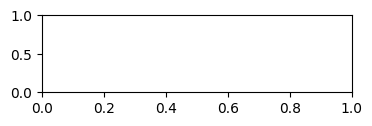

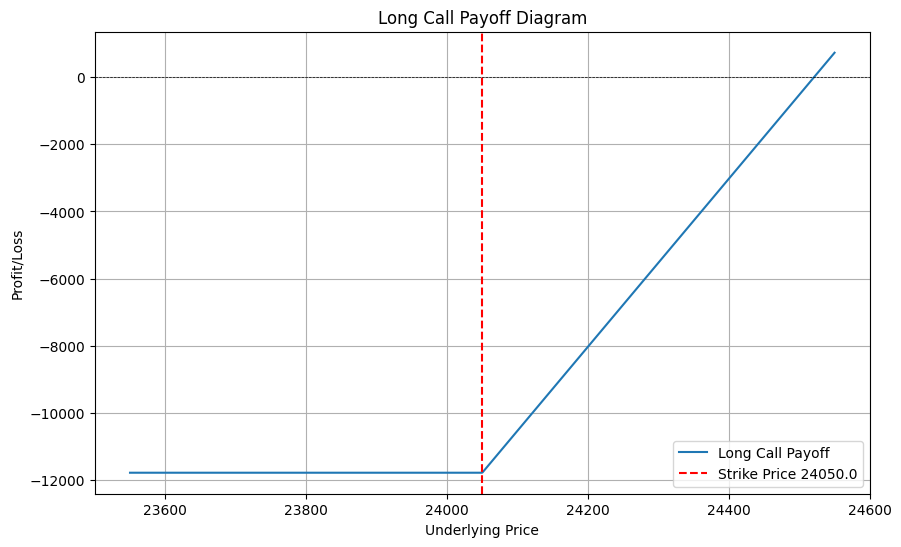

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-25-Jul-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 24324  # Current price of NIFTY
T = 20 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible long call strategies
long_calls = nearest_strikes
strategies = []

for K in long_calls:
    call_price = df_nearest[df_nearest['STRIKE'] == K]['Call_Price'].values[0]

    # Calculate max profit, max loss, reward/risk ratio, and probability of profit
    max_profit = np.inf
    max_loss = call_price
    reward_risk_ratio = np.inf

    # Assuming probability of profit based on ATM strike
    prob_profit = norm.cdf((np.log(S0 / K) + (r - 0.5 * df_nearest[df_nearest['STRIKE'] == K]['IV_CALLS'].values[0] ** 2) * T) / (df_nearest[df_nearest['STRIKE'] == K]['IV_CALLS'].values[0] * np.sqrt(T)))

    strategies.append({
        'Strike': K,
        'Max_Profit': max_profit,
        'Max_Loss': max_loss * lot_size,
        'Reward_Risk_Ratio': reward_risk_ratio,
        'Probability_of_Profit': prob_profit
    })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)

# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Probability_of_Profit': 0.5,
    'Max_Loss': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Probability_of_Profit', 'Max_Loss', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]

top_strategy['Strike'] = int(top_strategy['Strike'])
top_strategy['Max_Loss'] = int(top_strategy['Max_Loss'])
print(f"Top Long Call Strategy:\n{top_strategy}")
# Plot payoff graph for the top strategy
K = top_strategy['Strike']
call_price = df_nearest[df_nearest['STRIKE'] == K]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(K - 500, K + 500, 1000)

# Payoff function for the long call strategy
payoff = 25*np.where(
    S_range <= K,
    -call_price,
    S_range - K - call_price
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Long Call Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K, color='r', linestyle='--', label=f'Strike Price {K}')
plt.title('Long Call Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()


   Strike  Max_Profit  Max_Loss  Reward_Risk_Ratio  Probability_of_Profit
0   24300         inf      7725                inf               0.606582
1   24250         inf      8536                inf               0.639638
2   24350         inf      7025                inf               0.571258
3   24200         inf      9325                inf               0.673363
4   24400         inf      6250                inf               0.536833
5   24150         inf     10035                inf               0.711410
6   24450         inf      5815                inf               0.500581
7   24100         inf     10995                inf               0.739412
8   24500         inf      5125                inf               0.465686
9   24050         inf     11776                inf               0.777486
Top Long Call Strategy:
Strike                   2.405000e+04
Max_Profit                        inf
Max_Loss                 1.177600e+04
Reward_Risk_Ratio                 inf
Probabilit

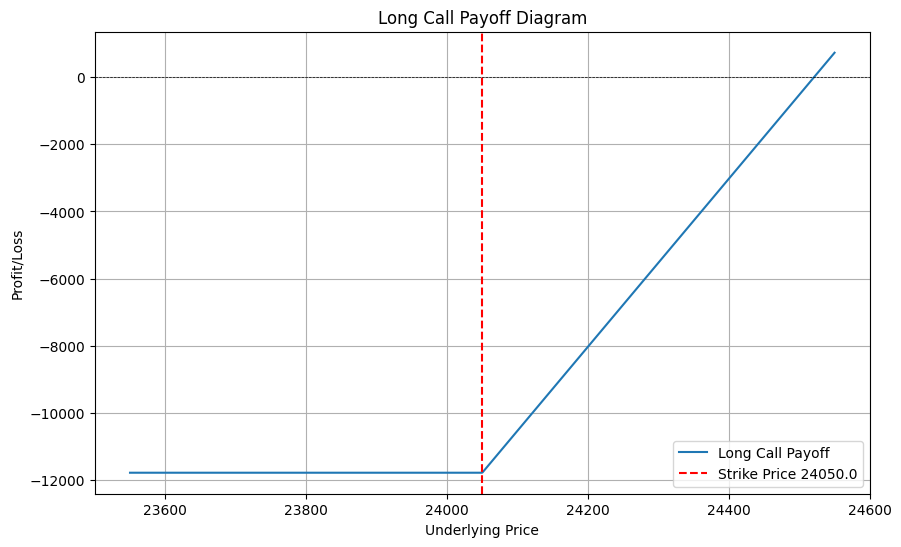

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools

# Load the data
file_path = '/content/option-chain-ED-NIFTY-25-Jul-2024.csv'
df = pd.read_csv(file_path)

# Extract relevant columns
df = df[['STRIKE', 'IV_CALLS', 'LTP_CALLS']]
df['STRIKE'] = df['STRIKE'].replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS'].replace('-', np.nan).astype(float)
df['LTP_CALLS'] = df['LTP_CALLS'].str.replace(',', '').astype(float)
df['IV_CALLS'] = df['IV_CALLS']/100
# Define constants
S0 = 24324  # Current price of NIFTY
T = 20 / 365  # Time to expiry
r = 0.10  # Risk-free rate
lot_size = 25  # Lot size

# Generate nearest 10 strike prices to the ATM
ATM_strike = df.iloc[(df['STRIKE'] - S0).abs().argsort()[:1]]['STRIKE'].values[0]
strike_prices = df['STRIKE'].unique()
nearest_strikes = sorted(strike_prices, key=lambda x: abs(x - ATM_strike))[:10]

# Filter relevant rows for nearest strikes and use LTP_CALLS directly
df_nearest = df[df['STRIKE'].isin(nearest_strikes)].copy()
df_nearest['Call_Price'] = df_nearest['LTP_CALLS']

# Generate all possible long call strategies
long_calls = nearest_strikes
strategies = []

for K in long_calls:
    call_price = df_nearest[df_nearest['STRIKE'] == K]['Call_Price'].values[0]

    # Calculate max profit, max loss, reward/risk ratio, and probability of profit
    max_profit = np.inf
    max_loss = call_price
    reward_risk_ratio = np.inf

    # Assuming probability of profit based on ATM strike
    prob_profit = norm.cdf((np.log(S0 / K) + (r - 0.5 * df_nearest[df_nearest['STRIKE'] == K]['IV_CALLS'].values[0] ** 2) * T) / (df_nearest[df_nearest['STRIKE'] == K]['IV_CALLS'].values[0] * np.sqrt(T)))

    strategies.append({
        'Strike': int(K),
        'Max_Profit': max_profit,
        'Max_Loss': int(max_loss * lot_size),
        'Reward_Risk_Ratio': reward_risk_ratio,
        'Probability_of_Profit': prob_profit
    })

# Create DataFrame from strategies list
strategies_df = pd.DataFrame(strategies)
print(strategies_df)

# TOPSIS method
def topsis(df, weights):
    df = df.copy()
    # Normalize the decision matrix
    norm_matrix = df / np.sqrt((df**2).sum())

    # Weighted normalized decision matrix
    weighted_matrix = norm_matrix * weights

    # Identify ideal and negative-ideal solutions
    ideal_solution = weighted_matrix.max()
    negative_ideal_solution = weighted_matrix.min()

    # Calculate the distance to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
    dist_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

    # Calculate the relative closeness to the ideal solution
    topsis_score = dist_to_neg_ideal / (dist_to_ideal + dist_to_neg_ideal)

    return topsis_score

# Define weights for each parameter
weights = pd.Series({
    'Probability_of_Profit': 0.5,
    'Max_Loss': 0.3,
    'Max_Profit': 0.2
})

# Rank strategies using TOPSIS
strategies_df['TOPSIS_Score'] = topsis(strategies_df[['Probability_of_Profit', 'Max_Loss', 'Max_Profit']], weights)
strategies_df['Rank'] = strategies_df['TOPSIS_Score'].rank(ascending=False)

# Display the top strategy
top_strategy = strategies_df.sort_values(by='Rank').iloc[0]
top_strategy['Strike'] = int(top_strategy['Strike'])
top_strategy['Max_Loss'] = int(top_strategy['Max_Loss'])
print(f"Top Long Call Strategy:\n{top_strategy}")

# Plot payoff graph for the top strategy
K = top_strategy['Strike']
call_price = df_nearest[df_nearest['STRIKE'] == K]['Call_Price'].values[0]

# Define the range of underlying prices at expiration
S_range = np.linspace(K - 500, K + 500, 1000)

# Payoff function for the long call strategy
payoff = 25*np.where(
    S_range <= K,
    -call_price,
    S_range - K - call_price
)

# Plotting the payoff graph
plt.figure(figsize=(10, 6))
plt.plot(S_range, payoff, label='Long Call Payoff')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(K, color='r', linestyle='--', label=f'Strike Price {K}')
plt.title('Long Call Payoff Diagram')
plt.xlabel('Underlying Price')
plt.ylabel('Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()
